# Train an anti-aliased U-net based GAN

## Imports and GPU identification

In [1]:
!pip install tensorflow-addons

import tensorflow as tf
import os
from PIL import Image
from scipy import special
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.python.client import device_lib
from datetime import datetime
import time
from IPython.display import clear_output
from google.colab import drive
drive.mount('/content/drive')

%load_ext tensorboard
%rm -rf ./logs/

print(device_lib.list_local_devices())
print(tf.config.experimental.get_memory_info("/device:GPU:0")['current'])

     |████████████████████████████████| 1.1 MB 7.8 MB/s 
Mounted at /content/drive
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2411652429562456357
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16154099712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6583825552832563574
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]
0


In [2]:
!ls /content/drive/MyDrive/drone-image-analysis/

generated_images_GAN_train_2022-05-15
IMG_2138.png
photos_2022-05-14
roman_photos
training_checkpoints_GAN_train_2022-05-14_
training_checkpoints_GAN_train_2022-05-15_


## Test Keras convolution
Find out what the Keras convolution automatic zero paddings are for padding = "SAME", depending on the input size and kernel size. For skip connections it is important that the data stays centered spatially. These tests need not be run for the rest of the notebook to work.

In [3]:
if True:
  print("Downsampling, even size input, even size kernel:")
  print("Input:")
  input_ = tf.ones((1, 8, 8, 1), dtype=tf.float32)
  print(input_[0, :, :, 0].numpy())
  print("Kernel:")
  kernel = tf.ones((4, 4, 1, 1), dtype=tf.float32)
  print(kernel[:, :, 0, 0].numpy())
  print("Output of strides = 2, padding = 'SAME' convolution:")
  conv = tf.nn.conv2d(input = input_, filters = kernel, strides = 2, padding = 'SAME')
  print(conv[0, :, :, 0].numpy())
  print("The output is properly centered.")
  print("Output size = input size / 2")

  print("\nDownsampling, odd size input, even size kernel:")
  print("Input:")
  input_ = tf.ones((1, 7, 7, 1), dtype=tf.float32)
  print(input_[0, :, :, 0].numpy())
  print("Kernel:")
  kernel = tf.ones((4, 4, 1, 1), dtype=tf.float32)
  print(kernel[:, :, 0, 0].numpy())
  print("Output of strides = 2, padding = 'SAME' convolution:")
  conv = tf.nn.conv2d(input = input_, filters = kernel, strides = 2, padding = 'SAME')
  print(conv[0, :, :, 0].numpy())
  print("Invalid output centering! Don't do this.")

  print("\nDownsampling, even size input, odd size kernel:")
  print("Input:")
  input_ = tf.ones((1, 8, 8, 1), dtype=tf.float32)
  print(input_[0, :, :, 0].numpy())
  print("Kernel:")
  kernel = tf.ones((3, 3, 1, 1), dtype=tf.float32)
  print(kernel[:, :, 0, 0].numpy())
  print("Output of strides = 2, padding = 'SAME' convolution:")
  conv = tf.nn.conv2d(input = input_, filters = kernel, strides = 1, padding = 'SAME')
  print(conv[0, :, :, 0].numpy())
  print("Invalid output centering! Don't do this.")

  print("\nDownsampling, odd size input, odd size kernel:")
  print("Input:")
  input_ = tf.ones((1, 9, 9, 1), dtype=tf.float32)
  print(input_[0, :, :, 0].numpy())
  print("Kernel:")
  kernel = tf.ones((5, 5, 1, 1), dtype=tf.float32)
  print(kernel[:, :, 0, 0].numpy())
  print("Output of strides = 2, padding = 'SAME' convolution:")
  conv = tf.nn.conv2d(input = input_, filters = kernel, strides = 1, padding = 'SAME')
  print(conv[0, :, :, 0].numpy())
  print("The output is properly centered.")
  print("Output size = (input size + 1) / 2")

Downsampling, even size input, even size kernel:
Input:
[[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]]
Kernel:
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Output of strides = 2, padding = 'SAME' convolution:
[[ 9. 12. 12.  9.]
 [12. 16. 16. 12.]
 [12. 16. 16. 12.]
 [ 9. 12. 12.  9.]]
The output is properly centered.
Output size = input size / 2

Downsampling, odd size input, even size kernel:
Input:
[[1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]]
Kernel:
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Output of strides = 2, padding = 'SAME' convolution:
[[ 9. 12. 12.  6.]
 [12. 16. 16.  8.]
 [12. 16. 16.  8.]
 [ 6.  8.  8.  4.]]
Invalid output centering! Don't do this.



In [4]:
if True:
  print("Upsampling, any size input, even size kernel:")
  print("Input:")
  input_ = tf.ones((1, 4, 4, 1), dtype=tf.float32)
  print(input_[0, :, :, 0].numpy())
  tile = tf.constant([[0, 0], [0, 4]], dtype=tf.float32)
  input_shape = input_.get_shape()
  tiles = tf.reshape(tf.tile(tile, [input_shape[-3], input_shape[-2]]), (1, input_shape[-3]*2, input_shape[-2]*2, 1))
  print("Diluted:")
  diluted = tf.repeat(tf.repeat(input_, repeats = 2, axis=2), repeats=2, axis=1)*tiles
  print(diluted[0, :, :, 0].numpy());
  print("Kernel:")
  kernel = tf.ones((4, 4, 1, 1), dtype=tf.float32)
  print(kernel[:, :, 0, 0].numpy())
  print("Output of strides = 1, padding = 'SAME' convolution:")
  conv = tf.nn.conv2d(input = diluted, filters = kernel, strides = 1, padding = 'SAME')
  print(conv[0, :, :, 0].numpy())
  print("The output is properly centered.")
  print("Output size = input size * 2")

  print("\nUpsampling, any size input, odd size kernel:")
  print("Input:")
  input_ = tf.ones((1, 4, 4, 1), dtype=tf.float32)
  print(input_[0, :, :, 0].numpy())
  tile = tf.constant([[0, 0], [0, 4]], dtype=tf.float32)
  input_shape = input_.get_shape()
  tiles = tf.reshape(tf.tile(tile, [input_shape[-3], input_shape[-2]])[1:,1:], (1, input_shape[-3]*2 - 1, input_shape[-2]*2 - 1, 1))
  print("Diluted (step 1):")
  diluted = tf.repeat(tf.repeat(input_, repeats = 2, axis=2), repeats=2, axis=1)[:,1:,1:,:]*tiles
  print(diluted[0, :, :, 0].numpy());
  print("Kernel:")
  kernel = tf.ones((3, 3, 1, 1), dtype=tf.float32)
  print(kernel[:, :, 0, 0].numpy())
  print("Output of strides = 1, padding = 'SAME' convolution:")
  conv = tf.nn.conv2d(input = diluted, filters = kernel, strides = 1, padding = 'SAME')
  print(conv[0, :, :, 0].numpy())
  print("The output is properly centered.")
  print("Output size = input size * 2 - 1")


Upsampling, any size input, even size kernel:
Input:
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Diluted:
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 4. 0. 4. 0. 4. 0. 4.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 4. 0. 4. 0. 4. 0. 4.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 4. 0. 4. 0. 4. 0. 4.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 4. 0. 4. 0. 4. 0. 4.]]
Kernel:
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Output of strides = 1, padding = 'SAME' convolution:
[[ 4.  8.  8.  8.  8.  8.  8.  4.]
 [ 8. 16. 16. 16. 16. 16. 16.  8.]
 [ 8. 16. 16. 16. 16. 16. 16.  8.]
 [ 8. 16. 16. 16. 16. 16. 16.  8.]
 [ 8. 16. 16. 16. 16. 16. 16.  8.]
 [ 8. 16. 16. 16. 16. 16. 16.  8.]
 [ 8. 16. 16. 16. 16. 16. 16.  8.]
 [ 4.  8.  8.  8.  8.  8.  8.  4.]]
The output is properly centered.
Output size = input size * 2

Upsampling, any size input, odd size kernel:
Input:
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Diluted (step 1):
[[4. 0. 4. 0. 4. 0. 4.]
 [0. 0. 0. 0. 0. 0. 0.]
 [4. 0. 4. 0. 4

## Circularly symmetric low-pass or anti-aliasing filter
Functions for generating a filter kernel with a parameterized cutoff frequency and kernel size

In [5]:
def circular_lowpass_kernel(omega_c, N):  # omega = cutoff frequency in radians (pi is max), N = horizontal size of the kernel, also its vertical size.
  with np.errstate(divide='ignore',invalid='ignore'):    
      kernel = np.fromfunction(lambda x, y: omega_c*special.j1(omega_c*np.sqrt((x - (N - 1)/2)**2 + (y - (N - 1)/2)**2))/(2*np.pi*np.sqrt((x - (N - 1)/2)**2 + (y - (N - 1)/2)**2)), [N, N])
  if N % 2:
      kernel[(N - 1)//2, (N - 1)//2] = omega_c**2/(4*np.pi)
  return kernel

def rotated_cosine_window(N):  # N = horizontal size of the targeted kernel, also its vertical size, must be odd.
  return np.fromfunction(lambda y, x: np.maximum(np.cos(np.pi/2*np.sqrt(((x - (N - 1)/2)/((N - 1)/2 + 1))**2 + ((y - (N - 1)/2)/((N - 1)/2 + 1))**2)), 0), [N, N])

def windowed_circular_lowpass_kernel(cutoff, kernel_size):
  return (circular_lowpass_kernel(cutoff, kernel_size)*rotated_cosine_window(kernel_size)).astype(np.float32);

def test_kernel(kernel):
  kernel_size = kernel.shape[0] #height, should be same as width

  print("Kernel:")
  plt.imshow(kernel, vmin=-0.25, vmax=0.25, cmap='bwr', extent=[-kernel_size/2, kernel_size/2, -kernel_size/2, kernel_size/2])
  plt.colorbar()
  plt.show()

  print("Frequency response:")
  freq_resp = np.abs(np.fft.fftshift(np.fft.fft2(np.roll(np.pad(kernel, 101, mode = 'constant', constant_values = 0), shift = (-kernel_size//2-99, -kernel_size//2-99), axis = (0, 1)))))
  plt.imshow(freq_resp, vmin=-1.2, vmax=1.2, cmap='bwr', extent=[-np.pi, np.pi, -np.pi, np.pi])
  plt.colorbar()
  plt.show()

## Load training target images and low-pass filter them

Note: Do NOT use the filtered PNG images as network input, because they have been quantized. They can be saved for visual inspection.

drive  sample_data
Even size kernel:
Kernel:


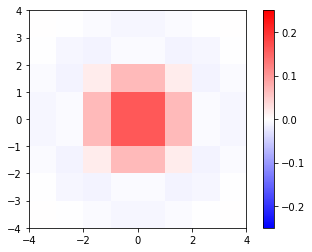

Frequency response:


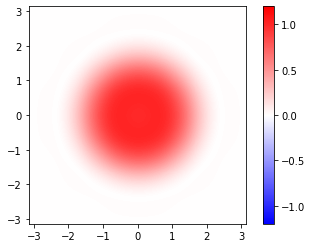

Odd size kernel:
Kernel:


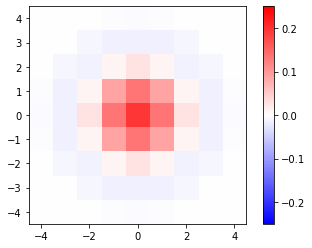

Frequency response:


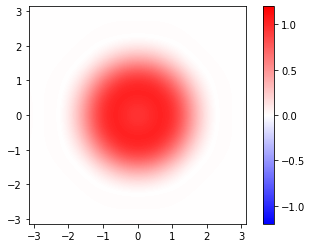

In [6]:
!ls
# Configuration
oversampling = 2  # Oversampling factor, 2 is a good choice
aa_even_kernel_size = 8 # Size of even sized antialiasing filter
aa_odd_kernel_size = aa_even_kernel_size + 1 # Size of odd sized antialiasing filter
batch_size = 1
discriminator_input_size = 512
data_dir = "/content/drive/MyDrive/drone-image-analysis"
photos_dir = data_dir + "/photos_2022-05-14"

print("Even size kernel:")
test_kernel(windowed_circular_lowpass_kernel(np.pi/oversampling, aa_even_kernel_size))
print("Odd size kernel:")
test_kernel(windowed_circular_lowpass_kernel(np.pi/oversampling, aa_odd_kernel_size))

def channeled_kernel(kernel_prototype, num_channels):
  kernel_expanded = tf.expand_dims(kernel_prototype, 2)
  kernel_repeated = tf.repeat(kernel_expanded, num_channels, axis=2)
  return tf.expand_dims(kernel_repeated, -1)

def tensorflow_srgb_to_linear(image):
  return tf.where( image >= 0.04045,((image + 0.055) / 1.055)**2.4, image/12.92 )

def numpy_linear_to_srgb(image):
  return np.where( image < 0.0031308, image * 12.92, 1.055 * np.clip(image, 0, 1)**(1.0 / 2.4)) - 0.055

def load_and_filter_image(filepath, channeled_kernel):
  image = tf.io.decode_image(tf.io.read_file(filepath), channels=3, dtype=tf.float32)
  image = image + tf.random.uniform(image.shape, 0, 1/255) - tf.random.uniform(image.shape, 0, 1/255)
  image = tensorflow_srgb_to_linear(image)
  image = tf.nn.depthwise_conv2d([image], channeled_kernel, [1, 1, 1, 1], "VALID")[0]
  return image

In [7]:
try:
  train_dataset_filenames = tf.data.Dataset.list_files(photos_dir + "/*.jpg")
except:
  print("error")

print("Number of image files = " + str(train_dataset_filenames.cardinality().numpy()));
train_dataset = []
for filepath in train_dataset_filenames:
  train_dataset.append(load_and_filter_image(filepath, channeled_kernel(windowed_circular_lowpass_kernel(np.pi/oversampling, aa_even_kernel_size), 3)).numpy())
  print(train_dataset[-1].shape)
print("Length of train_dataset_images = " + str(len(train_dataset)));

Number of image files = 19
(4601, 3449, 3)
(4455, 3449, 3)
(4601, 3449, 3)
(4601, 3449, 3)
(4601, 3449, 3)
(4601, 3449, 3)
(4601, 3449, 3)
(4266, 3449, 3)
(4601, 3449, 3)
(4601, 3449, 3)
(4601, 3449, 3)
(4601, 3449, 3)
(4382, 3449, 3)
(4601, 3449, 3)
(4601, 3449, 3)
(4601, 3449, 3)
(4353, 3449, 3)
(4601, 3449, 3)
(4601, 3449, 3)
Length of train_dataset_images = 19


## Isotropic lowpass filtering layers
These layers apply a circularly symmmetrical lowpass filter. They preserve spatial centering of the data to facilitate skip connections and center cropping in the network.

`IsotropicLowpassFilterLayer` accepts `strides = 1` to preserve the feature map size and `strides = 2` to downsample it to half size. With `strides = 1`, the kernel size must be odd. With downsampling, only even input and kernel sizes are supported, resulting in even-sized output. `cutoff` is the cutoff frequency (before downsampling).

`IsotropicLowpassFilteredUpsampleLayer` doubles the spatial size of the feature map. `cutoff` is the cutoff frequency after upsampling. `kernel_size` must be even.

In [8]:
class IsotropicLowpassFilterLayer(tf.keras.layers.Layer):
  def __init__(self, cutoff, kernel_size, strides = 1, **kwargs):
    super(IsotropicLowpassFilterLayer, self).__init__(**kwargs)
    self.kernel_size = kernel_size
    self.strides = strides        
    assert self.strides == 1 or self.strides == 2, "Accepted values for strides are 1 and 2. Tuples or arrays are not accepted."
    if self.strides == 1:
      assert self.kernel_size % 2 == 1, "kernel_size must be odd when strides = 1"
    if self.strides == 2:
      assert self.kernel_size % 2 == 0, "kernel_size must be even when strides = 2"

    self.kernel_prototype = windowed_circular_lowpass_kernel(cutoff, self.kernel_size)

  def build(self, input_shape):
    self.filtering = tf.keras.layers.DepthwiseConv2D(self.kernel_size, trainable=False, use_bias=False, padding='same', strides=self.strides, weights=[channeled_kernel(self.kernel_prototype, input_shape[-1])])

  def call(self, inputs):
    return self.filtering(inputs)

def get_upsample_multiplication_tensor(input_shape):
  tile = tf.constant([[0, 0], [0, 4]], dtype=tf.float32)
  return tf.reshape(tf.tile(tile, [input_shape[-3], input_shape[-2]]), (1, input_shape[-3]*2, input_shape[-2]*2, 1))

class IsotropicLowpassFilteredUpsampleLayer(tf.keras.layers.Layer):
  def __init__(self, cutoff, kernel_size, **kwargs):
    super(IsotropicLowpassFilteredUpsampleLayer, self).__init__(**kwargs)
    self.kernel_size = kernel_size
    assert self.kernel_size % 2 == 0, "kernel_size must be even"
    self.multiply = tf.keras.layers.Multiply()
    #self.zeropadding = tf.keras.layers.ZeroPadding2D(padding = ((0, 1), (0, 1)))  # not needed for input even -> output even
    self.kernel_prototype = windowed_circular_lowpass_kernel(cutoff, kernel_size)
    self.kernel_size = kernel_size

  def build(self, input_shape):
    self.multiplication_tensor = get_upsample_multiplication_tensor(input_shape)
    self.filtering = tf.keras.layers.DepthwiseConv2D(self.kernel_size, trainable=False, use_bias=False, padding='same', weights=[channeled_kernel(self.kernel_prototype, input_shape[-1])])

  def call(self, inputs):
    x = tf.repeat(tf.repeat(inputs, repeats = 2, axis=2), repeats=2, axis=1)
    x = self.multiply([x, self.multiplication_tensor])
    #x = self.zeropadding(x)  # not needed for input even -> output even
    x = self.filtering(x)
    return x    

if False:      
  print("Test input:")
  input_shapes = (aa_odd_kernel_size + 2, aa_odd_kernel_size + 2, 3)
  eye = tf.repeat(tf.expand_dims(tf.repeat(tf.expand_dims(tf.eye(input_shapes[0], input_shapes[1]), -1), repeats = input_shapes[2], axis = -1), 0), repeats = batch_size, axis = 0)
  plt.imshow(eye[0])
  plt.show()

  def TestModel(input_shapes):
    inputs = tf.keras.Input(input_shapes)
    outputs = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)    
    return model

  print("Isotropic lowpass filtered:")
  model = TestModel(input_shapes)
  output = model(eye)
  plt.imshow(output[0])
  plt.show()

  def TestModel(input_shapes):
    inputs = tf.keras.Input(input_shapes)
    outputs = IsotropicLowpassFilteredUpsampleLayer(np.pi/oversampling, aa_even_kernel_size)(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)    
    return model

  print("Isotropic lowpass filtered upsampled:")
  model = TestModel(input_shapes)
  output = model(eye)
  plt.imshow(output[0])
  plt.show()

## RandomCropper
Crop images randomly. This should be done in the beginning of each epoch by calling RandomCropper.recrop()

In [9]:
import random

class RandomCropper:
  def __init__(self, images):
    self.images = images

  def recrop(self, size):
    image = random.choice(self.images)
    y = random.randrange(image.shape[0] - size)
    x = random.randrange(image.shape[1] - size)
    return image[y:y + size, x:x + size, :]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample training target image:


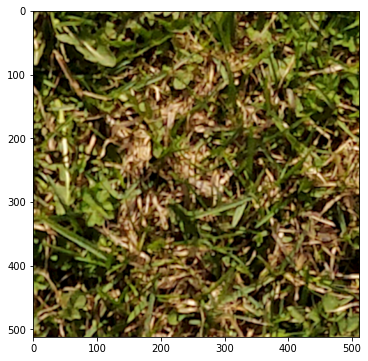

In [10]:
print("Sample training target image:")
train_dataset_cropper = RandomCropper(train_dataset)
train_image = train_dataset_cropper.recrop(discriminator_input_size)
plt.figure(figsize = (6,6))
plt.imshow(numpy_linear_to_srgb(train_image))
plt.show()

## Generator model
Define the generator network, parameterized by input image size.

Generator network:


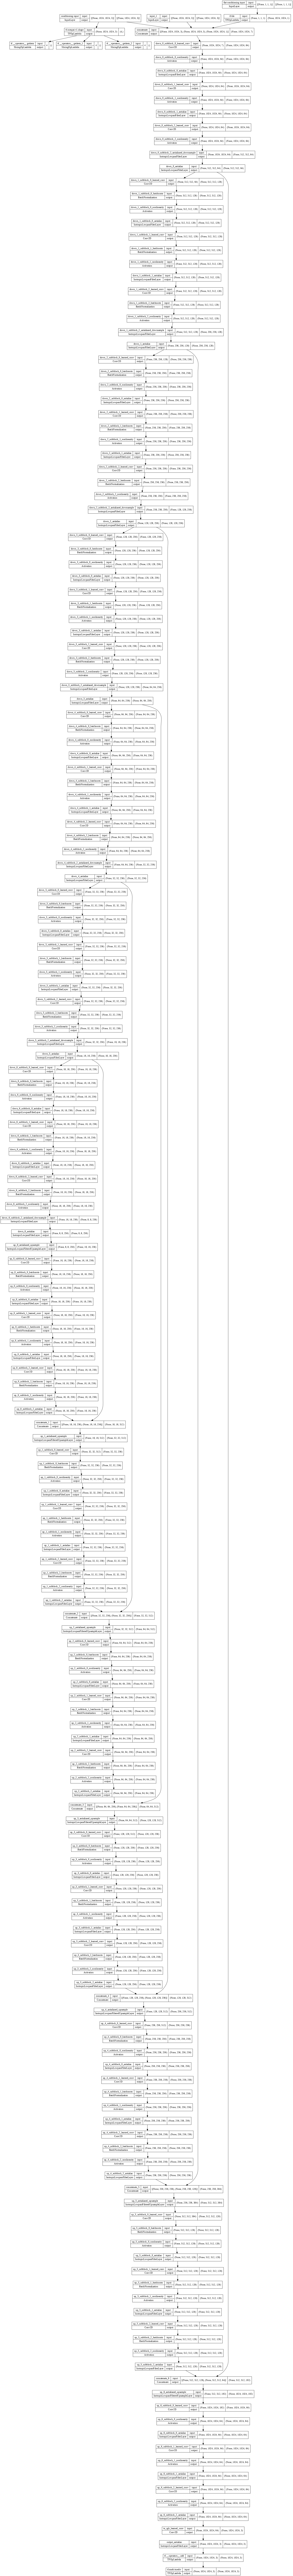

In [11]:
def Generator(input_size, down_nonlinearity, up_nonlinearity, initializer, learned_kernel_size, num_sublayers, num_resamplings, max_features, use_skip_connections):      
  c = tf.keras.Input(shape = (input_size, input_size, 3), name = "conditioning input")
  z = tf.keras.Input(shape = (input_size, input_size, 3), name = "random input")
  z_flat = tf.keras.Input(shape = (1, 1, 1), name = "flat conditioning input")

  c_shape = tf.shape(c)

  z = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size, name = "input_antialias")(z)
  x = tf.keras.layers.Concatenate()([z, c, tf.tile(z_flat, [c_shape[0], c_shape[1], c_shape[2], 1])])

  skip_connection_stack = []
  #skip_connection_stack.append(x)

  n = 64
  for j in range(num_resamplings):
    for i in range(num_sublayers):
      x = tf.keras.layers.Conv2D(max_features if n > max_features else n, learned_kernel_size, kernel_initializer=initializer, use_bias = False, padding="same", name = f"down_{j}_subblock_{i}_learned_conv")(x)
      if j > 0:
        x = tf.keras.layers.BatchNormalization(name = f"down_{j}_subblock_{i}_batchnorm")(x) 
      x = tf.keras.layers.Activation(down_nonlinearity, name = f"down_{j}_subblock_{i}_nonlinearity")(x)
      x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size if i < num_sublayers - 1 else aa_even_kernel_size, strides = 1 if i < num_sublayers - 1 else 2, name = f"down_{j}_subblock_{i}_antialias" if i < num_sublayers - 1 else f"down_{j}_subblock_{i}_antialiased_downsample")(x) 
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size, name = f"down_{j}_antialias")(x)
    if j < num_resamplings - 1:
      skip_connection_stack.append(x)
    n *= 2

  for j in range(num_resamplings):
    n //= 2
    if use_skip_connections and j > 0:
      skip_connection = skip_connection_stack.pop()
      x = tf.keras.layers.Concatenate()([x, skip_connection])
    x = IsotropicLowpassFilteredUpsampleLayer(np.pi/oversampling, aa_even_kernel_size, name = f"up_{j}_antialiased_upsample")(x)
    for i in range(num_sublayers):
      x = tf.keras.layers.Conv2D(max_features if n > max_features else n, learned_kernel_size, kernel_initializer=initializer, use_bias = False, padding="same", name = f"up_{j}_subblock_{i}_learned_conv")(x)
      if j < num_resamplings - 1:
        x = tf.keras.layers.BatchNormalization(name = f"up_{j}_subblock_{i}_batchnorm")(x)
      x = tf.keras.layers.Activation(up_nonlinearity, name = f"up_{j}_subblock_{i}_nonlinearity")(x)
      x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size, name = f"up_{j}_subblock_{i}_antialias")(x)

  x = tf.keras.layers.Conv2D(3, learned_kernel_size, kernel_initializer=initializer, use_bias=False, padding="same", name = "to_rgb_learned_conv")(x)
  #x = tf.keras.layers.Activation("tanh", name = "output_nonlinearity")(x)
  x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size, name = "output_antialias")(x)
  #x = tf.keras.layers.Add()([x, c])
  #x = tf.keras.layers.CenterCrop(x.get_shape()[-3]//2, x.get_shape()[-2]//2, name = "output_crop")(x)

  return  tf.keras.Model(inputs=[c, z, z_flat], outputs=(x + 1)/2, name = "Generator")

generator_input_size = discriminator_input_size*2

generator = Generator(generator_input_size, tf.keras.layers.LeakyReLU(), tf.keras.layers.LeakyReLU(), "glorot_uniform", learned_kernel_size = 5, num_sublayers = 3, num_resamplings = 7, max_features = 256, use_skip_connections = True)
generator.build((generator_input_size, generator_input_size, 1))

print("Generator network:")
display(tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64))

## Image smoother for conditioning input

Smooth out the image so that it can be used as conditioning input to the generator


Image smoother network:


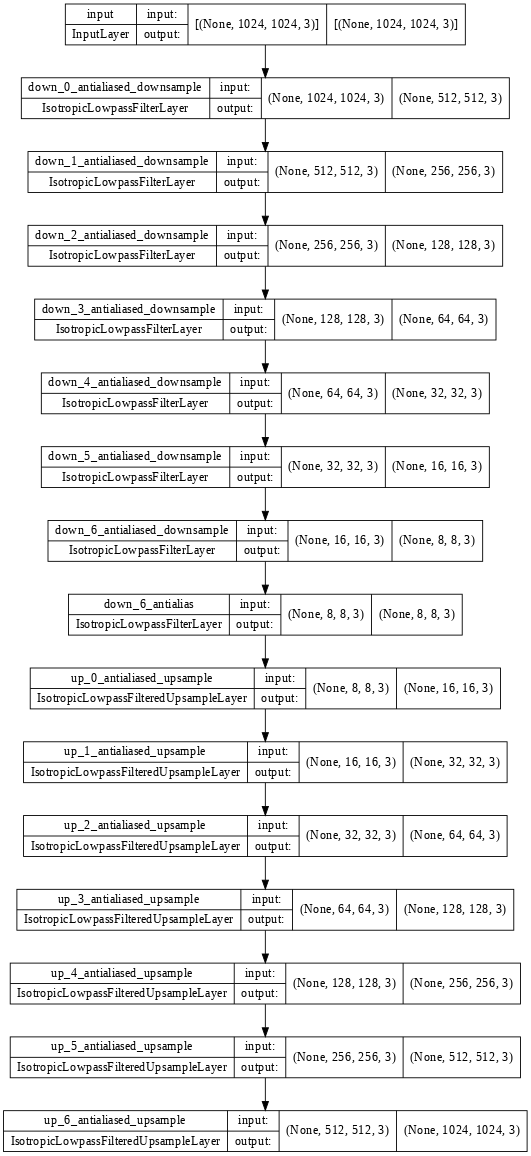

In [12]:
def ImageSmoother(input_size, num_resamplings):      
  inputs = tf.keras.Input(shape = (input_size, input_size, 3), name = "input")

  x = inputs

  for j in range(num_resamplings):
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_even_kernel_size, 2, name = f"down_{j}_antialiased_downsample")(x)

  x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size, name = f"down_{j}_antialias")(x)

  for j in range(num_resamplings):
    x = IsotropicLowpassFilteredUpsampleLayer(np.pi/oversampling, aa_even_kernel_size, name = f"up_{j}_antialiased_upsample")(x)

  return  tf.keras.Model(inputs=inputs, outputs=x, name = "ImageSmoother")

imageSmoother = ImageSmoother(generator_input_size, num_resamplings = 7)
imageSmoother.build((generator_input_size, generator_input_size, 3))

print("Image smoother network:")
display(tf.keras.utils.plot_model(imageSmoother, show_shapes=True, dpi=64))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample training target image:


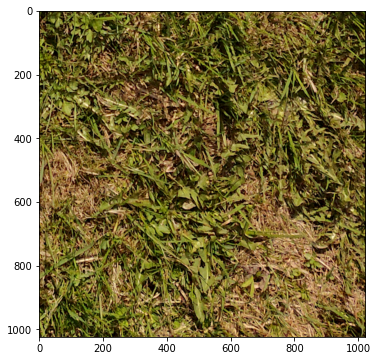

Smoothed:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


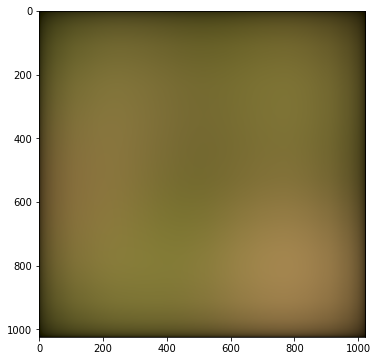

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator input:


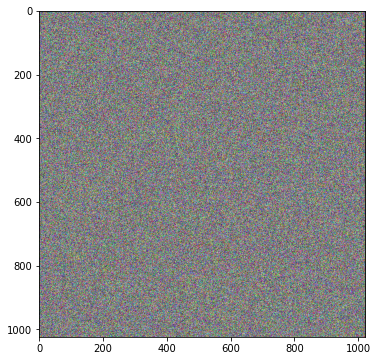

Generator output:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


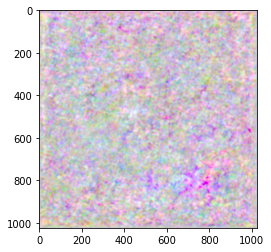

In [13]:
# Generate, display
z = tf.random.normal((1, generator_input_size, generator_input_size, 3))
z_flat = tf.random.normal((1, 1, 1, 1))

print("Sample training target image:")
train_dataset_cropper = RandomCropper(train_dataset)
train_image = train_dataset_cropper.recrop(generator_input_size)
plt.figure(figsize = (6,6))
plt.imshow(numpy_linear_to_srgb(train_image))
plt.show()

print("Smoothed:")
smoothed_train_image = imageSmoother(tf.expand_dims(train_image, 0))
plt.figure(figsize = (6,6))
plt.imshow(numpy_linear_to_srgb(smoothed_train_image[0]))
plt.show()

print("Generator input:")
plt.figure(figsize = (6,6))
plt.imshow((z[0].numpy() + 1)/2)
plt.show()
print("Generator output:")
x = generator([smoothed_train_image, z, z_flat], training = True)[0]
plt.imshow(numpy_linear_to_srgb(x.numpy()))
plt.show()

## Generator loss

In [14]:
mse = tf.keras.losses.MeanSquaredError() #tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Discriminator model

Discriminator network:


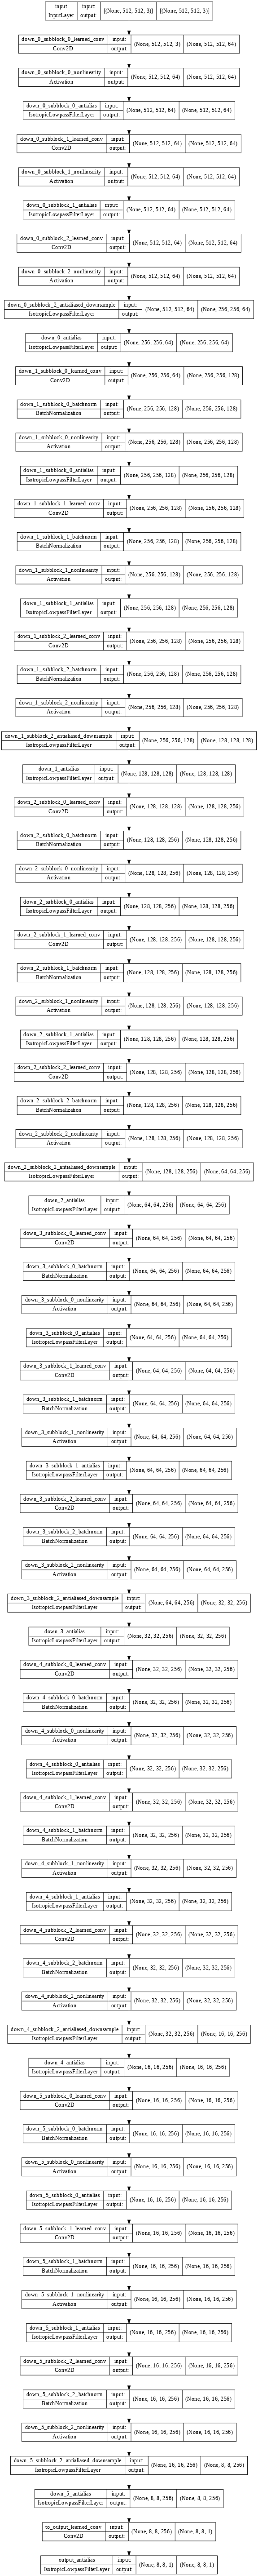

In [15]:
def Discriminator(input_size, down_nonlinearity, initializer, learned_kernel_size, num_sublayers, num_resamplings, max_features):      
    inputs = tf.keras.Input(shape = (input_size, input_size, 3), name = "input")
  
    x = inputs

    n = 64
    for j in range(num_resamplings):
        for i in range(num_sublayers):
            x = tf.keras.layers.Conv2D(max_features if n > max_features else n, learned_kernel_size, kernel_initializer=initializer, use_bias=True, padding="same", name = f"down_{j}_subblock_{i}_learned_conv")(x)
            if j > 0:
                x = tf.keras.layers.BatchNormalization(name = f"down_{j}_subblock_{i}_batchnorm")(x)             
            x = tf.keras.layers.Activation(down_nonlinearity, name = f"down_{j}_subblock_{i}_nonlinearity")(x)
            x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size if i < num_sublayers - 1 else aa_even_kernel_size, strides = 1 if i < num_sublayers - 1 else 2, name = f"down_{j}_subblock_{i}_antialias" if i < num_sublayers - 1 else f"down_{j}_subblock_{i}_antialiased_downsample")(x)
        x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size, name = f"down_{j}_antialias")(x)
        n *= 2

    x = tf.keras.layers.Conv2D(1, learned_kernel_size, kernel_initializer=initializer, use_bias=True, padding="same", name = "to_output_learned_conv")(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size, name = "output_antialias")(x)

    return  tf.keras.Model(inputs=inputs, outputs=x, name = "Discriminator")

discriminator = Discriminator(discriminator_input_size, tf.keras.layers.LeakyReLU(), "glorot_uniform", learned_kernel_size = 5, num_sublayers = 3, num_resamplings = 6, max_features = 256)
discriminator.build((discriminator_input_size, discriminator_input_size, 3))

print("Discriminator network:")
display(tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample training target image:


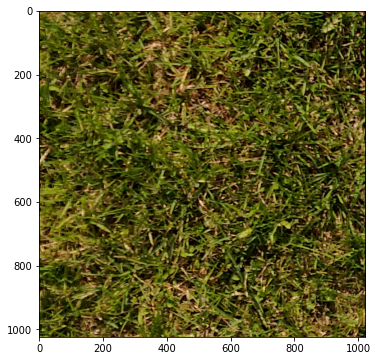

Showing crop:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


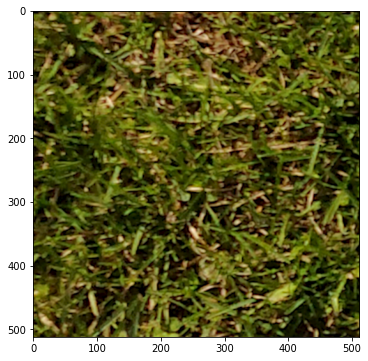

45 deg rotation and crop:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


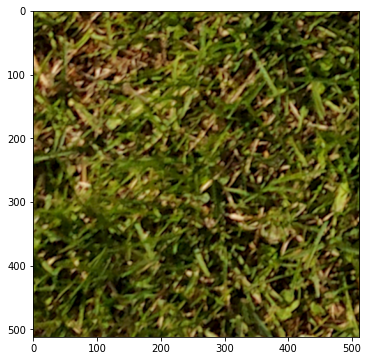

Discriminator output:


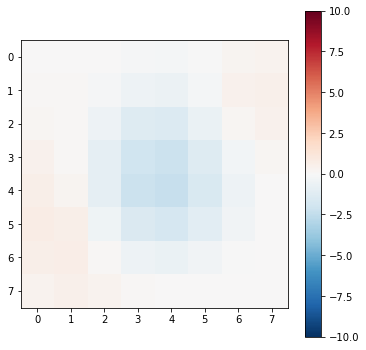

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Smoothed:


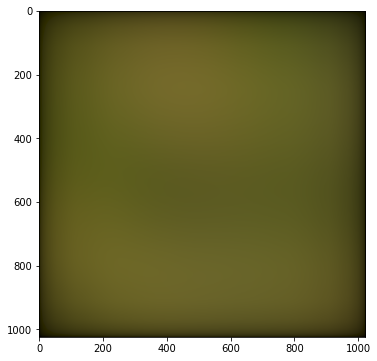

Sample generated image, before training:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


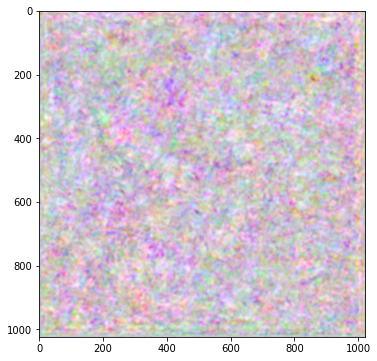

Discriminator output (for cropped generated image):


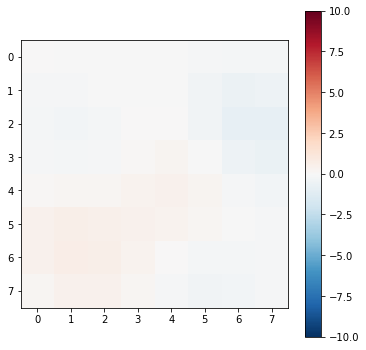

In [16]:

import tensorflow_addons as tfa
z = tf.random.normal((1, generator_input_size, generator_input_size, 3))
z_flat = tf.random.normal((1, 1, 1, 1))

print("Sample training target image:")
train_dataset_cropper = RandomCropper(train_dataset)
train_image = train_dataset_cropper.recrop(generator_input_size)
smoothed_train_image = imageSmoother(tf.expand_dims(train_image, 0))
plt.figure(figsize = (6,6))
plt.imshow(numpy_linear_to_srgb(train_image))
plt.show()

print("Showing crop:")
plt.figure(figsize = (6,6))
plt.imshow(numpy_linear_to_srgb(tf.keras.layers.CenterCrop(discriminator_input_size, discriminator_input_size)(train_image)))
plt.show()

print("45 deg rotation and crop:")
train_image = tfa.image.rotate(train_image, np.pi/4, "bilinear")
train_image = tf.keras.layers.CenterCrop(discriminator_input_size, discriminator_input_size)(train_image)
plt.figure(figsize = (6,6))
plt.imshow(numpy_linear_to_srgb(train_image))
plt.show()

print("Discriminator output:")
disc_out = discriminator(train_image[tf.newaxis, ...], training=True)
plt.figure(figsize = (6,6))
plt.imshow(disc_out[0, ..., -1], cmap='RdBu_r')
plt.clim(-10,10)
plt.colorbar()
plt.show()

print("Smoothed:")
plt.figure(figsize = (6,6))
plt.imshow(numpy_linear_to_srgb(smoothed_train_image[0]))
plt.show()

print("Sample generated image, before training:")
generated_image = generator([smoothed_train_image, z, z_flat], training = True)[0]
plt.figure(figsize = (6,6))
plt.imshow(numpy_linear_to_srgb(generated_image.numpy()))
plt.show()

print("Discriminator output (for cropped generated image):")
disc_out = discriminator(tf.keras.layers.CenterCrop(discriminator_input_size, discriminator_input_size)(generated_image)[tf.newaxis, ...], training=True)
plt.figure(figsize = (6,6))
plt.imshow(disc_out[0, ..., -1], cmap='RdBu_r')
plt.clim(-10,10)
plt.colorbar()
plt.show()

## Discriminator loss

## Optimizers

In [17]:
# tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.5, beta_2=0.99, epsilon=1e-07)
#generator_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)
#discriminator_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)
generator_optimizer = tf.keras.optimizers.SGD(1e-4) # start with 1e-3, then change it to 1e-4
discriminator_optimizer = tf.keras.optimizers.SGD(1e-4)

## Set up model checkpoint loading or saving

In [18]:
experiment_name = "GAN_train_2022-05-15"

In [19]:
checkpoint_dir = data_dir + '/training_checkpoints_' + experiment_name + "_"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator=generator, discriminator=discriminator)

gen_image_dir = data_dir + '/generated_images_' + experiment_name
if not os.path.exists(gen_image_dir):
  os.makedirs(gen_image_dir)

## Load checkpoint

In [20]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Save checkpoint

In [21]:
#checkpoint.save(file_prefix=checkpoint_prefix)

## Train the GAN

In [ ]:
num_epochs = 100000
display_every = 10 # How many epochs to skip between data displays
save_image_every = 100
save_checkpoint_every = 1000

#checkpoint.save(file_prefix=checkpoint_prefix)
#checkpoint.restore(file_prefix=checkpoint_prefix)

#  with summary_writer.as_default():
#    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
#    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

test_image = train_dataset_cropper.recrop(generator_input_size)
test_image_batch = test_image[tf.newaxis, ...]
test_c = imageSmoother(test_image_batch)
test_z = tf.random.normal((1, generator_input_size, generator_input_size, 3))
test_z_flat = tf.random.normal((1, 1, 1, 1))
if True:
  image = Image.fromarray(np.clip(np.rint(numpy_linear_to_srgb(test_image)*255), 0, 255).astype(np.uint8))
  image.save(gen_image_dir + "/" + str(datetime.now()) + " ref.jpg")

@tf.function # (jit_compile=True)
def train_step(training_image_batch):
    c = imageSmoother(training_image_batch)
    z = tf.random.normal((batch_size, generator_input_size, generator_input_size, 3))
    z_flat = tf.random.normal((batch_size, 1, 1, 1))
    angle = tf.random.normal((batch_size,), 0, np.pi/32)
    disc_real_input = tfa.image.rotate(training_image_batch, angle + tf.random.normal((batch_size,), 0, np.pi/64), "bilinear")
    disc_real_input = disc_real_input + tf.random.normal((batch_size, generator_input_size, generator_input_size, 3), 0, 1/256)
    disc_real_input = tf.keras.layers.CenterCrop(discriminator_input_size, discriminator_input_size)(disc_real_input)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

      disc_real_output = tf.keras.layers.CenterCrop(2, 2)(discriminator(disc_real_input, training=True))

      gen_output = generator([c, z, z_flat], training=True)
      gen_output = gen_output - imageSmoother(gen_output) # !
      gen_output = gen_output + c #!
      disc_fake_input = tfa.image.rotate(gen_output, angle + tf.random.normal((batch_size,), 0, np.pi/64), "bilinear")
      disc_fake_input = disc_fake_input + tf.random.normal((batch_size, generator_input_size, generator_input_size, 3), 0, 1/256)
      disc_fake_input = tf.keras.layers.CenterCrop(discriminator_input_size, discriminator_input_size)(disc_fake_input)

      disc_generated_output = tf.keras.layers.CenterCrop(2, 2)(discriminator(disc_fake_input, training=True))
      gen_direct_loss = mse(tf.keras.layers.CenterCrop(2, 2)(imageSmoother(gen_output)), tf.keras.layers.CenterCrop(2, 2)(c))
      gen_adversarial_loss = mse(tf.ones_like(disc_generated_output), disc_generated_output)

      tf.print(gen_adversarial_loss)
      tf.print(gen_direct_loss)
      tf.print()
      gen_loss =  gen_adversarial_loss + gen_direct_loss
      disc_loss = (mse(tf.ones_like(disc_real_output), disc_real_output) + mse(tf.math.negative(tf.ones_like(disc_generated_output)), disc_generated_output))

      generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
      discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return training_image_batch, gen_output
    #disc_real_input, disc_fake_input

def fit():
  for epoch in range(num_epochs + 1):
    training_image = train_dataset_cropper.recrop(generator_input_size) * np.random.lognormal(0, 0.1)
    training_image_batch = training_image[tf.newaxis, ...]

    real_example, fake_example = train_step(training_image_batch)

    if epoch % display_every == 0:
      clear_output(wait=True)
      plt.figure(figsize = (10, 10))
      plt.imshow(numpy_linear_to_srgb(real_example[0].numpy()))
      plt.show()
      plt.figure(figsize = (10, 10))
      plt.imshow(numpy_linear_to_srgb(fake_example[0].numpy()))
      plt.show()

    if epoch % save_image_every == 0:
      # for layer in model.layers:
      # layer.trainable = False
      # if isinstance(layer, keras.layers.normalization.BatchNormalization):
      #  layer._per_input_updates = {}
      # trainable attribute in BatchNormalization now disables the updates of the batch statistics (i.e. if trainable == False the layer will now run 100% in inference mode).
      # training=False
      # https://github.com/keras-team/keras/pull/9965
      # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization#output_shape
      gen_output = generator([test_c, test_z, test_z_flat], training=True)
      gen_output = gen_output - imageSmoother(gen_output)
      gen_output = gen_output + test_c
      image = Image.fromarray(np.clip(np.rint(numpy_linear_to_srgb(gen_output[0].numpy())*255), 0, 255).astype(np.uint8))
      image.save(gen_image_dir + "/" + str(datetime.now()) + ".jpg")

    if (epoch + 1) % save_checkpoint_every == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

fit()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
